# Part 3, Topic 3: DPA on Firmware Implementation of AES (HARDWARE)

---
**THIS IS NOT THE COMPLETE TUTORIAL - see file with `(MAIN)` in the name.**

---

First you'll need to select which hardware setup you have. You'll need to select a `SCOPETYPE`, a `PLATFORM`, and a `CRYPTO_TARGET`. `SCOPETYPE` can either be `'OPENADC'` for the CWLite/CW1200 or `'CWNANO'` for the CWNano. `PLATFORM` is the target device, with `'CWLITEARM'`/`'CW308_STM32F3'` being the best supported option, followed by `'CWLITEXMEGA'`/`'CW308_XMEGA'`, then by `'CWNANO'`. `CRYPTO_TARGET` selects the crypto implementation, with `'TINYAES128C'` working on all platforms. An alternative for `'CWLITEXMEGA'` targets is `'AVRCRYPTOLIB'`. For example:

```python
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CRYPTO_TARGET='TINYAES128C'
SS_VER='SS_VER_1_1'
```

In [1]:
# this is for stm32f3 masked aes implementation
# for STM32F3
SCOPETYPE = 'OPENADC'
PLATFORM = 'CW308_STM32F3'
CRYPTO_TARGET='TINYAES128C' 
SS_VER='SS_VER_1_1'

board = 'stm32f3'

In [2]:
# this is for xmega masked aes implementation
# for XMEGA
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEXMEGA'
CRYPTO_TARGET='TINYAES128C' 
SS_VER='SS_VER_1_1'

board = 'xmega'

The following code will build the firmware for the target.

In [48]:
%run "/Users/chenggang/work_dir/chipWhisper/chipwhisperer-jupyter/Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍


In [49]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER"
cd /Users/chenggang/work_dir/chipWhisper/chipwhisperer/hardware/victims/firmware/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3

Building for platform CWLITEXMEGA with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
rm -f -- simpleserial-aes-CWLITEXMEGA.hex
rm -f -- simpleserial-aes-CWLITEXMEGA.eep
rm -f -- simpleserial-aes-CWLITEXMEGA.cof
rm -f -- simpleserial-aes-CWLITEXMEGA.elf
rm -f -- simpleserial-aes-CWLITEXMEGA.map
rm -f -- simpleserial-aes-CWLITEXMEGA.sym
rm -f -- simpleserial-aes-CWLITEXMEGA.lss
rm -f -- objdir-CWLITEXMEGA/*.o
rm -f -- objdir-CWLITEXMEGA/*.lst
rm -f -- simpleserial-aes.s simpleserial.s XMEGA_AES_driver.s uart.s usart_driver.s xmega_hal.s aes.s aes-independant.s
rm -f -- simpleserial-aes.d simpleserial.d XMEGA_AES_driver.d uart.d usart_driver.d xmega_hal.d aes.d aes-independant.d
rm -f -- simpleserial-aes.i simpleserial.i XMEGA_AES_driver.i uart.i usart_driver.i xmega_hal.i aes.i aes-independant.i
.
Welcome to another exciting ChipWhisperer target build!!
avr-gcc (Homebrew AVR GCC 9.3.0_3) 9.3.0
Copyright (C) 2019 Free Software Foundation, Inc

In [50]:
cw.program_target(scope, prog, "/Users/chenggang/work_dir/chipWhisper/chipwhisperer/hardware/victims/firmware/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM))

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 4211 bytes


In [51]:
from tqdm import tnrange
import numpy as np
import time

ktp = cw.ktp.Basic()
key, text = ktp.next()
target.set_key(key)

scope.adc.samples = 5000
ktp = cw.ktp.Basic()

In [6]:
# run this when you want to change the key
key, text = ktp.next()
print(key)
ktp.fixed_key = False
ktp.fixed_key
key, text = ktp.next()
print(key)
ktp.fixed_key = True
key, text = ktp.next()
print(key)

CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')
CWbytearray(b'49 3c 6d c4 7b 19 ed e0 a6 d0 f6 57 34 0e 1b 5e')
CWbytearray(b'49 3c 6d c4 7b 19 ed e0 a6 d0 f6 57 34 0e 1b 5e')


In [52]:
# run this when you want to change the key
target.set_key(key)
for i in range(3):
    key, text = ktp.next()
    print(key)
    print(text)
    print('==============')

CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')
CWbytearray(b'47 80 3c bb 6f fd 5e 20 3b 1c c9 1f c7 84 d2 b8')
CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')
CWbytearray(b'72 a5 ef c0 c2 4e 23 5d 77 dc 61 65 12 80 ad d2')
CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')
CWbytearray(b'0c a7 01 d8 a5 03 78 e8 1d 7a 8e 20 d6 1c cd 98')


For this tutorial, we'll need to capture around 2500 traces:

In [53]:
trace_array = []
textin_array = []
N = 2
for i in tnrange(N, desc='Capturing traces'):
    scope.arm()
    
    target.simpleserial_write('p', text)
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 16)
    
    trace_array.append(scope.get_last_trace())
    textin_array.append(text)
    
    key, text = ktp.next() 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  after removing the cwd from sys.path.


Capturing traces:   0%|          | 0/2 [00:00<?, ?it/s]

In [37]:
print(key)

CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')


<IPython.core.display.Javascript object>


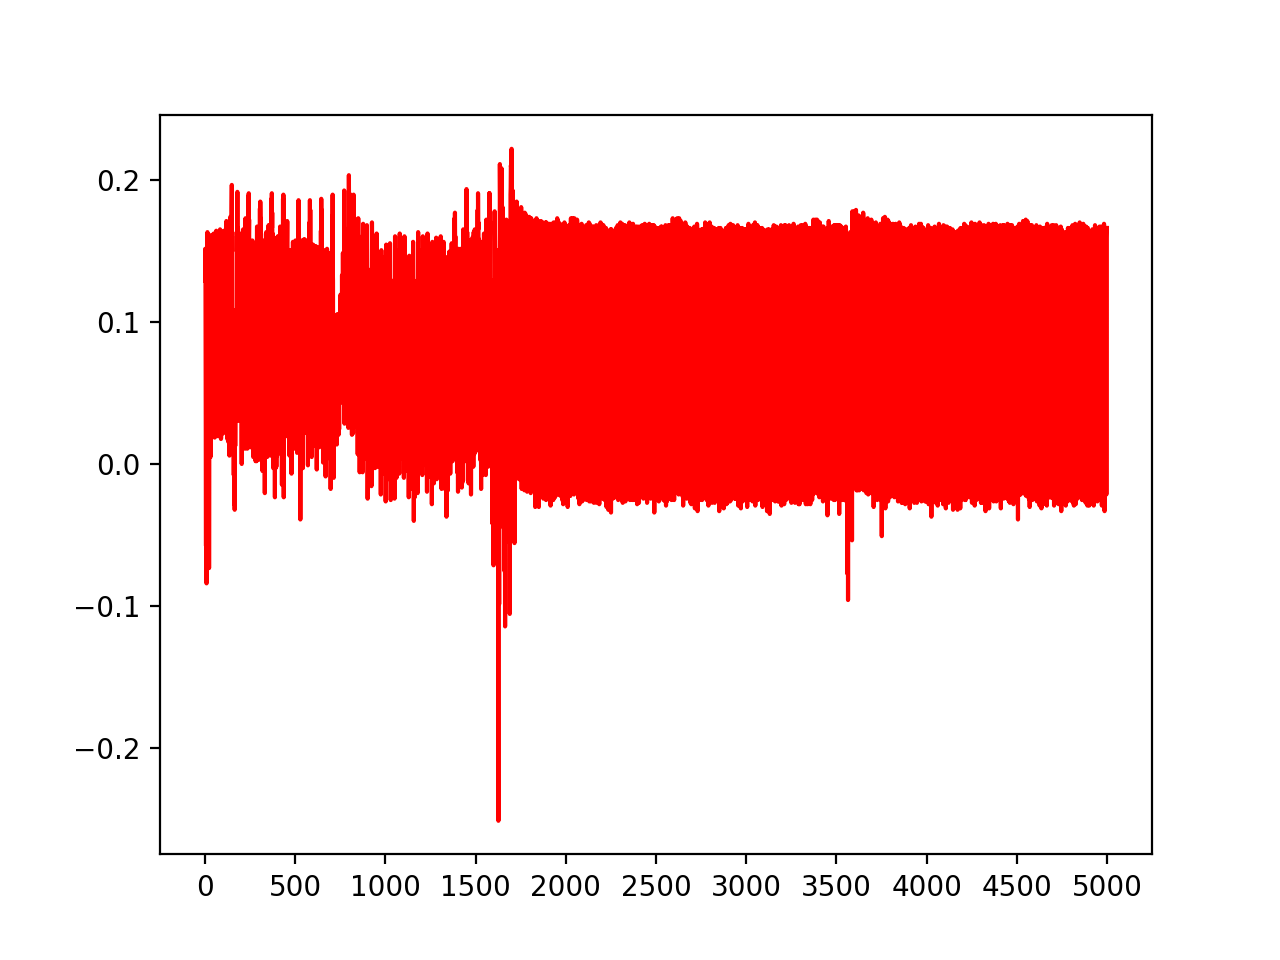

In [54]:
%matplotlib notebook
import matplotlib.pylab as plt
from matplotlib.pyplot import MultipleLocator

x_locator = MultipleLocator(500)
ax = plt.gca()
ax.xaxis.set_major_locator(x_locator)

plt.plot(trace_array[1], color='r')

In [47]:
import os
save_dir = '/Users/chenggang/work_dir/chipWhisper/figures/xmega_4_attack_window'
os.makedirs(save_dir, exist_ok=True)
fig_path = os.path.join(save_dir, 'run_mixcolum.png')
plt.savefig(fig_path)

In [11]:
# prepare the datas
import numpy as np
trace_array = np.float32(trace_array)
print(trace_array.shape)
store_key = list(key)
store_key = np.array(store_key)
print(store_key.shape)
print(store_key)

if 'stm32f3' == board:
    attack_window = (1200, 2200)
elif 'xmega' == board:
    attack_window = (1800, 2800)
else:
    raise
print('attack_window: ', attack_window)

(20000, 5000)
(16,)
[ 73  60 109 196 123  25 237 224 166 208 246  87  52  14  27  94]
attack_window:  (1800, 2800)


In [12]:
# used to save the data
import os
dataDir = '/Users/chenggang/work_dir/chipWhisper/data/jimmy_board_laptop_xmega/'
os.makedirs(dataDir, exist_ok=True)
outpath = os.path.join(dataDir, 'val_diff_key.npz')
np.savez(outpath, trace_mat=trace_array, textin_mat=textin_array, key=store_key, attack_window=attack_window)
del store_key, trace_array, textin_array

In [13]:
hex_key = [hex(val) for val in key]
print(hex_key)

['0x49', '0x3c', '0x6d', '0xc4', '0x7b', '0x19', '0xed', '0xe0', '0xa6', '0xd0', '0xf6', '0x57', '0x34', '0xe', '0x1b', '0x5e']


visual one trace to see the different step of encryption

In [167]:
dir_path = '/home/carl/work_dir/power_fingerprinting/figures/vis_traces/stm32f3_new'
import os
os.makedirs(dir_path, exist_ok=True)

In [14]:
# disconnect the board
scope.dis()
target.dis()